In [72]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.matlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider, fixed

In [73]:
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

In [74]:
from network_utils import (
    gaussian, create3Dplot, create2Dplot, show_slice,
    plot_all_sensory_fields, plot_sensory_input_subplots,
    plot_initial_activation, plot_normalised_sensory_grid,
    plot_final_activation, generate_evenly_spaced_centers,
    generate_circular_trajectory, generate_edge_to_edge_trajectory,
    plot_trajectory_over_PC_idx, plot_trajectory_over_PC_idx, view_bump_with_slider_3D, 
    show_bump_3D
)

In [75]:
# === Step 1: Initialise network parameters and matrices === #

# Grid and network dimensions
rows = 10
cols = 10
nCells = rows * cols

# Sensory and recurrent configuration
nSensoryCells = 50
Sigma = 2.5                 # Spread of the Gaussian tuning curve
NetThreshold = 0.7       # Threshold for activation
nIterationsPerTimestep = 10  # Recurrent iterations per timestep
blend_factor = 0.9          # Influence of new input vs. previous state

# Allocate memory for the recurrent weight matrix
weightsMat = np.zeros((rows, cols, nCells))

# Create an index grid for place cells
PC_idx = np.arange(nCells).reshape(rows, cols)

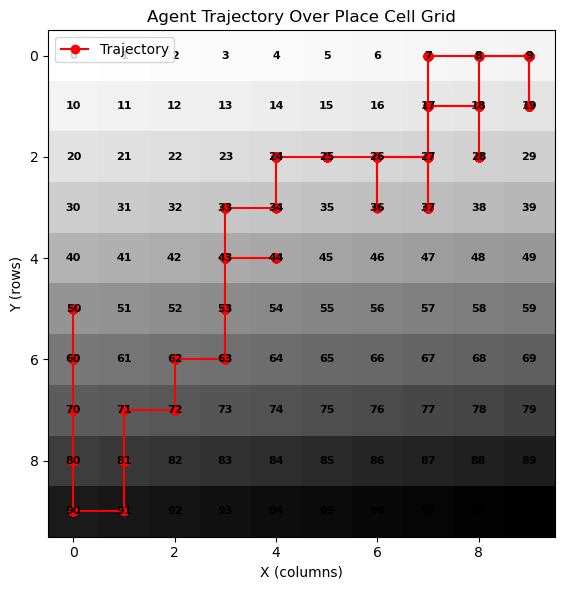

In [76]:
# Load the data
data = np.load("sargolini.npz")
positions = data['pos']   # shape: (T, 2)
times = data['t']

# Limit to first 50 timesteps
positions = positions[:1000]

# Grid dimensions
rows, cols = 10, 10

# Convert continuous positions to discrete grid indices
x_norm = np.clip((positions[:, 0] * cols).astype(int), 0, cols - 1)
y_norm = np.clip((positions[:, 1] * rows).astype(int), 0, rows - 1)

# Create trajectory as list of (row, col)
trajectory_positions = list(zip(y_norm, x_norm))

# Plot the trajectory over the place cell grid
plot_trajectory_over_PC_idx(trajectory_positions, PC_idx)

In [77]:
# === Step 2: Initialise the recurrent weights matrix === #
# Each cell has a weight of 1 with itself and 0.5 with its immediate neighbours

weightsMat = np.zeros((rows, cols, nCells))  # Reset in case already defined

for k in range(nCells):
    # Get the (row, col) location of the k-th place cell
    r, c = np.where(PC_idx == k)
    r, c = r[0], c[0]

    # Assign weight of 1 to itself
    weightsMat[r, c, k] = 1.0

    # Assign weight of 0.5 to immediate neighbors (up, down, left, right)
    for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        nr, nc = r + dr, c + dc
        if 0 <= nr < rows and 0 <= nc < cols:
            weightsMat[nr, nc, k] = 0.5

In [78]:
# Step 4: Create a sheet of sensory cells with Gaussian firing fields
SensoryFiringFields = np.zeros((rows, cols, nSensoryCells))

# Generate center positions
centers = generate_evenly_spaced_centers(rows, cols, nSensoryCells)

# Create coordinate grid
X, Y = np.meshgrid(np.arange(rows), np.arange(cols))

# Compute Gaussian firing fields
for i, (cx, cy) in enumerate(centers):
    SensoryFiringFields[:, :, i] = gaussian(X, Y, cx, cy, Sigma)

# Plot all sensory fields using the saved utility function
plot_all_sensory_fields(SensoryFiringFields, PC_idx)

In [79]:
# STEP 5: Create a weights matrix between the sensory cells and attractor cells
sensoryWeights = np.zeros((nSensoryCells, nCells))

# Iterate over each place cell
for cell in range(nCells):
    r, c = np.where(PC_idx == cell) # find the position of the cell in the PC sheet

    # Extract firing rates from all sensory cells at this location
    sensoryWeights[:, cell] = SensoryFiringFields[r, c,:]


print("sensory Weights matrix shape:", sensoryWeights.shape)

sensory Weights matrix shape: (50, 100)


In [80]:
sensoryInputGrids = []  # to store (sensoryInputGridNormalised, pcRow, pcCol, timestep)

for t, (pcRow, pcCol) in enumerate(trajectory_positions):
    print(f"\n--- Timestep {t+1}: Position ({pcRow}, {pcCol}) ---")

    # Step 1: Find the sensory activity at that position
    currentSensoryActivity = SensoryFiringFields[pcRow, pcCol, :]

    # Step 2: Transpose to column vector
    currentSensoryActivity = np.transpose([currentSensoryActivity])

    # Step 3: Replicate across columns to match the weight matrix shape
    currentSensoryActivity = np.matlib.repmat(currentSensoryActivity, 1, nCells)

    # Step 4: Elementwise multiply and sum to get final sensory input
    sensoryInput = currentSensoryActivity * sensoryWeights
    sensoryInput = np.sum(sensoryInput, axis=0)
    sensoryInput = sensoryInput * 40
      # Scale the input

    # Step 5: Reshape into 2D grid
    sensoryInputGrid = sensoryInput.reshape(rows, cols)

    # Step 6: Normalise the grid for visualisation or comparison
    sensoryInputGridNormalised = sensoryInputGrid / np.max(sensoryInputGrid)

    # Store the normalised grid with the PC location and timestep
    sensoryInputGrids.append((sensoryInputGridNormalised, pcRow, pcCol, t+1))

    # You can now use sensoryInputGridNormalised in your attractor update loop


--- Timestep 1: Position (2, 8) ---

--- Timestep 2: Position (2, 8) ---

--- Timestep 3: Position (2, 8) ---

--- Timestep 4: Position (2, 8) ---

--- Timestep 5: Position (2, 8) ---

--- Timestep 6: Position (2, 8) ---

--- Timestep 7: Position (2, 8) ---

--- Timestep 8: Position (2, 8) ---

--- Timestep 9: Position (2, 8) ---

--- Timestep 10: Position (2, 8) ---

--- Timestep 11: Position (2, 8) ---

--- Timestep 12: Position (2, 8) ---

--- Timestep 13: Position (2, 8) ---

--- Timestep 14: Position (1, 8) ---

--- Timestep 15: Position (1, 8) ---

--- Timestep 16: Position (1, 8) ---

--- Timestep 17: Position (1, 8) ---

--- Timestep 18: Position (1, 8) ---

--- Timestep 19: Position (1, 8) ---

--- Timestep 20: Position (1, 8) ---

--- Timestep 21: Position (1, 8) ---

--- Timestep 22: Position (1, 8) ---

--- Timestep 23: Position (1, 8) ---

--- Timestep 24: Position (1, 8) ---

--- Timestep 25: Position (1, 8) ---

--- Timestep 26: Position (1, 8) ---

--- Timestep 27: Pos

plot_sensory_input_subplots(sensoryInputGrids, PC_idx, nCols=6)

In [81]:
# Reset initial NetAct to a random state (you can customize this if needed)
NetAct = np.random.rand(rows, cols) * 0.5
NetAct = NetAct / np.max(NetAct)  # Normalize


In [82]:
results = np.zeros((len(sensoryInputGrids), rows, cols))


for i, (sensoryInputGridNormalised, pcRow, pcCol, timestep) in enumerate(sensoryInputGrids):
    print(f"\n--- Running network update for timestep {timestep} ---")

    # Option 1: Blend sensory input into current NetAct
    NetAct = blend_factor * sensoryInputGridNormalised + (1 - blend_factor) * NetAct

    for _ in range(nIterationsPerTimestep):
        NetInput = np.zeros((rows, cols))

        for k in range(nCells):
            row, col = np.where(PC_idx == k)
            NetInput += weightsMat[:, :, k] * NetAct[row, col]

        # Option 2: Add sensory input again during recurrent loop
        NetInput += sensoryInputGridNormalised

        NetInput = NetInput - np.min(NetInput)
        if np.max(NetInput) > 0:
            NetInput = NetInput / np.max(NetInput)
        NetInput = NetInput * (NetInput >= NetThreshold)

        NetAct = NetInput.copy()

    results[i, :, :] = NetAct
    peak = np.unravel_index(np.argmax(NetAct), NetAct.shape)
    print(f"Timestep {timestep} bump peak: {peak}")

# create3Dplot(results, trajectory_positions, PC_idx, sensoryInputGrids)


--- Running network update for timestep 1 ---
Timestep 1 bump peak: (2, 7)

--- Running network update for timestep 2 ---
Timestep 2 bump peak: (2, 7)

--- Running network update for timestep 3 ---
Timestep 3 bump peak: (2, 7)

--- Running network update for timestep 4 ---
Timestep 4 bump peak: (2, 7)

--- Running network update for timestep 5 ---
Timestep 5 bump peak: (2, 7)

--- Running network update for timestep 6 ---
Timestep 6 bump peak: (2, 7)

--- Running network update for timestep 7 ---
Timestep 7 bump peak: (2, 7)

--- Running network update for timestep 8 ---
Timestep 8 bump peak: (2, 7)

--- Running network update for timestep 9 ---
Timestep 9 bump peak: (2, 7)

--- Running network update for timestep 10 ---
Timestep 10 bump peak: (2, 7)

--- Running network update for timestep 11 ---
Timestep 11 bump peak: (2, 7)

--- Running network update for timestep 12 ---
Timestep 12 bump peak: (2, 7)

--- Running network update for timestep 13 ---
Timestep 13 bump peak: (2, 7)

---

In [ ]:
interact(
    show_bump_3D,
    matrix=fixed(results),               # Your bump matrix: shape [timesteps, rows, cols]
    PC_idx=fixed(PC_idx),               # Optional overlay of place cell indices
    timestep=IntSlider(min=0, max=results.shape[0]-1, step=1, value=0)  # <-- match this name
)

interactive(children=(IntSlider(value=0, description='timestep', max=999), Output()), _dom_classes=('widget-in…

<function network_utils.show_bump_3D(matrix, PC_idx, timestep)>